<a href="https://colab.research.google.com/github/sridharsakkari/Demand-Forecasting/blob/master/Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/sridharsakkari/Demand-Forecasting.git

Cloning into 'Demand-Forecasting'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import plotly.graph_objects as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Step 1:

#Problem Statement : 

One of the largest retail chains in the world wants to use their vast data source to build an efficient forecasting model to predict the sales for each SKU in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis. 

The goal of this project is to accurately forecast the weekly sales of every product at every store for next 12 weeks.

#Step 2 : 

Import the training and test data 

In [3]:
train_data = pd.read_csv('/content/Demand-Forecasting/train_data_sales.csv')
test_data = pd.read_csv('/content/Demand-Forecasting/test_data_sales.csv')

train_data_raw = train_data.copy()
test_data_raw = test_data.copy()

In [ ]:
train_data.shape

(150150, 9)

In [4]:
train_data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [ ]:
#.set_index('record_ID',inplace = True,drop =True)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [6]:
train_data['store_id'] = train_data['store_id'].astype('str')
train_data['sku_id'] = train_data['sku_id'].astype('str')

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  object 
 3   sku_id           150150 non-null  object 
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 10.3+ MB


In [8]:
train_data['week'] = pd.to_datetime(train_data['week'],dayfirst=True)

In [9]:
train_data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52


# Details of Each column: 

1. record_ID : Unique Id for each store and sku combination. 

2. week : Starting date of every week

3. store_id : Unique ID for every store

4. sku_id : Unique ID for every product

5. total_price : sales price of every product

6. base_price : base price

7. is_featured_sku : is it the featured item of week

8. is_display_sku : is the product on the display at a prominent place

9. units_sold : total units sold at the store

In [10]:
train_data['year'] = train_data['week'].dt.year
train_data['month'] = train_data['week'].dt.month
train_data['week_num'] = train_data['week'].dt.week

In [11]:
# check for na values

train_data.isna().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
year               0
month              0
week_num           0
dtype: int64

In [12]:
# one value of total_price is na. So that value can either be replaced or removed. In this case, the na values will be removed

train_data.fillna(0,inplace = True)

In [ ]:
train_data.isna().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
year               0
month              0
week_num           0
dtype: int64

# Step 3: Exploratory Data Analysis 

## Univariate Analysis

In [13]:
units_sold_weekly_tot = train_data.groupby(['week'])['units_sold'].aggregate(np.sum).reset_index().sort_values('week')
units_sold_weekly_tot['year'] = units_sold_weekly_tot['week'].dt.year
units_sold_weekly_tot['week_num'] = units_sold_weekly_tot['week'].dt.week



In [61]:
import plotly.express as px
plt.rcParams['figure.figsize'] = (20,10)
px.bar(units_sold_weekly_tot,x= 'week', y='units_sold',color = 'week_num')


In [15]:
#extracting mean sales w.r.t store_id and item_ids

units_sold_mean_store = train_data.groupby(['week','store_id'])[['units_sold']].aggregate(np.sum).reset_index().sort_values('units_sold',ascending = False)
units_sold_mean_items = train_data.groupby(['week','sku_id'])[['units_sold']].aggregate(np.sum).reset_index().sort_values('units_sold',ascending = False)

units_sold_mean_store['year'] = units_sold_mean_store['week'].dt.year
units_sold_mean_store['week_num'] = units_sold_mean_store['week'].dt.week

units_sold_mean_items['year'] = units_sold_mean_items['week'].dt.year
units_sold_mean_items['week_num'] = units_sold_mean_items['week'].dt.week



In [16]:
px.scatter_3d(z = 'week_num', y = 'units_sold',x = 'store_id',data_frame = units_sold_mean_store,color = 'store_id',size= 'units_sold')

In [17]:
total_price_mean_store = train_data.groupby(['week','store_id'])['total_price'].aggregate(np.mean).reset_index().sort_values('total_price',ascending = False)
base_price_mean_store = train_data.groupby(['week','store_id'])['base_price'].aggregate(np.mean).reset_index().sort_values('base_price',ascending = False)

total_price_mean_items = train_data.groupby(['week','sku_id'])['total_price'].aggregate(np.mean).reset_index().sort_values('total_price',ascending = False)
base_price_mean_items = train_data.groupby(['week','sku_id'])['base_price'].aggregate(np.mean).reset_index().sort_values('base_price',ascending = False)

In [18]:
units_sold_mean_store.head()

,week,store_id,units_sold,year,week_num
369,2011-02-14,9845,4691,2011,7
5309,2012-05-15,9845,3660,2012,20
367,2011-02-14,9823,3544,2011,7
304,2011-02-14,8023,3512,2011,7
5233,2012-05-08,9845,3487,2012,19


In [19]:
units_sold_weekly = train_data.groupby(['week_num'])['units_sold'].aggregate(np.mean).reset_index().sort_values('week_num')
base_price_weekly = train_data.groupby(['week_num'])['base_price'].aggregate(np.mean).reset_index().sort_values('base_price')
total_price_weekly = train_data.groupby(['week_num'])['total_price'].aggregate(np.mean).reset_index().sort_values('total_price')

weekly_data_1 = pd.merge(units_sold_weekly,base_price_weekly,how='inner')
weekly_data = pd.merge(weekly_data_1,total_price_weekly,how = 'inner')

In [20]:
plt.rcParams['figure.figsize'] = (30,30)
px.scatter_3d(data_frame = weekly_data,x = 'units_sold',y='base_price',z='total_price',color = 'week_num',size = 'units_sold')

In [21]:
store_units_sold = units_sold_mean_store.groupby(['store_id'])['units_sold'].aggregate(np.mean).reset_index().sort_values('units_sold',ascending = False)
items_units_sold = units_sold_mean_items.groupby(['sku_id'])['units_sold'].aggregate(np.mean).reset_index().sort_values('units_sold',ascending = False)

In [22]:
store_ids = train_data['store_id'].unique()

df1 = train_data[['sku_id','units_sold']][train_data['store_id'] == store_ids[0]].groupby('sku_id').aggregate(np.mean)
for i in range(1,len(store_ids)):
  
  df2 = train_data[['sku_id','units_sold']][train_data['store_id'] == store_ids[i]].groupby('sku_id').aggregate(np.mean)
  df1 = pd.concat((df1,df2),axis=1,join = 'outer',sort = False)

data_store_items = df1
data_store_items.columns = store_ids
data_store_items = data_store_items.reset_index()

In [23]:
data_store_items.head()

,index,8091,8095,8094,8063,8023,8058,8222,8121,8218,8317,8319,8392,8398,8400,8422,8438,8555,8562,8869,8991,8911,9001,9043,9092,9112,9132,9147,9164,9178,9190,9221,9250,9273,9279,9281,9328,9371,9442,9430,9439,9425,9432,9436,9456,9479,9481,9490,9498,9532,9578,9672,9611,9613,9632,9680,9700,9713,9731,9745,9770,9789,9813,9823,9837,9809,9845,9872,9876,9879,9880,9881,9890,9909,9954,9961,9984
0,216233,29.107692,92.723077,55.946154,32.246154,121.607692,44.761538,95.253846,35.623077,26.323077,59.861538,37.584615,32.115385,59.023077,38.576923,27.138462,51.246154,26.246154,46.746154,68.061538,41.707692,27.684615,NaN,36.969231,25.484615,83.353846,31.707692,51.923077,44.584615,16.738462,74.692308,49.023077,68.215385,45.369231,32.515385,57.700000,34.715385,29.961538,39.992308,43.907692,26.600000,NaN,29.923077,40.753846,29.284615,31.369231,73.923077,32.553846,57.507692,54.446154,33.192308,49.161538,63.015385,77.853846,38.376923,21.500000,12.053846,40.738462,38.576923,54.692308,30.792308,16.600000,46.253846,105.415385,45.930769,44.330769,105.353846,36.330769,33.069231,35.200000,49.392308,59.407692,47.276923,60.792308,28.815385,63.423077,34.423077
1,216418,26.376923,167.007692,88.230769,47.246154,248.376923,98.453846,174.107692,50.246154,45.707692,NaN,NaN,NaN,104.569231,58.646154,41.869231,84.938462,27.330769,148.192308,124.692308,86.807692,49.684615,NaN,85.038462,66.607692,205.284615,NaN,97.469231,121.523077,NaN,NaN,38.338462,204.184615,241.638462,72.107692,41.153846,75.084615,70.538462,68.192308,75.276923,21.261538,49.661538,46.792308,30.761538,43.307692,83.869231,153.861538,56.361538,29.307692,58.546154,60.153846,90.123077,203.992308,241.800000,28.738462,38.153846,10.376923,129.046154,73.823077,154.038462,32.553846,43.100000,26.838462,160.807692,62.307692,94.461538,220.307692,92.300000,28.130769,45.746154,70.592308,148.846154,82.907692,51.938462,NaN,131.576923,15.507692
2,216419,28.307692,97.830769,96.769231,39.584615,222.830769,85.238462,104.669231,NaN,37.215385,54.307692,NaN,NaN,71.576923,59.992308,37.369231,81.176923,25.984615,102.853846,94.984615,87.161538,34.846154,8.423077,53.769231,45.807692,178.200000,15.023077,81.492308,98.023077,NaN,51.161538,NaN,144.107692,46.669231,71.576923,46.284615,65.561538,48.830769,45.400000,53.415385,31.030769,41.500000,50.423077,NaN,35.130769,88.184615,132.738462,50.715385,26.469231,64.569231,58.023077,70.938462,138.300000,197.461538,24.876923,40.476923,NaN,105.761538,40.361538,103.169231,NaN,46.553846,23.253846,103.238462,49.538462,85.423077,169.961538,77.992308,NaN,59.823077,72.069231,113.100000,68.053846,46.192308,48.961538,100.923077,54.576923
3,216425,25.669231,77.200000,26.746154,NaN,85.015385,39.369231,80.807692,19.323077,10.546154,20.523077,15.407692,16.323077,45.969231,37.715385,NaN,25.892308,NaN,46.315385,61.138462,23.553846,14.853846,NaN,31.092308,11.353846,63.292308,12.815385,55.376923,36.976923,NaN,28.453846,18.500000,57.415385,13.184615,19.392308,21.200000,18.538462,27.876923,27.838462,31.538462,13.084615,9.615385,18.607692,NaN,11.738462,20.769231,67.007692,14.038462,29.253846,26.707692,23.592308,40.969231,57.823077,72.961538,15.361538,13.530769,NaN,37.376923,35.792308,38.069231,NaN,NaN,20.415385,69.484615,41.592308,36.884615,91.292308,20.792308,NaN,19.900000,26.330769,46.969231,47.038462,41.153846,13.161538,58.569231,18.169231
4,217390,29.469231,141.584615,45.569231,30.953846,233.776923,84.807692,141.423077,28.730769,21.792308,49.646154,22.046154,20.607692,101.961538,39.469231,23.069231,47.892308,22.346154,104.407692,135.015385,46.700000,24.546154,NaN,68.330769,27.784615,124.169231,NaN,93.453846,90.069231,NaN,44.061538,38.284615,128.146154,23.061538,33.692308,29.861538,32.630769,61.453846,58.276923,61.853846,NaN,15.100000,30.376923,24.392308,16.253846,40.323077,124.838462,28.784615,31.815385,52.661538,56.461538,78.161538,121.584615,145.915385,26.200000,15.861538,NaN,77.623077,NaN,96.723077,17.146154,20.392308,27.107692,156.846154,68.361538,73.738462,150.976923,41.676923,20.146154,28.138462,4

In [24]:
val = data_store_items.values[:,1:].T.reshape(-1,1)
idx = []
idx_0 = list(data_store_items['index'])
for i in range(len(idx_0)):
  idx = idx + idx_0

data_store_items_reshape = pd.concat((pd.DataFrame(idx),pd.DataFrame(val)),axis = 1)
data_store_items_reshape.columns = ['item_id','units_sold']
data_store_items_reshape['store_idx'] = pd.DataFrame(np.repeat(store_ids,len(idx_0)))



In [25]:
plt.rcParams['figure.figsize'] = (10,10)
df = data_store_items_reshape.fillna(0)
#sns.stripplot(x = 'store_idx',y = 'units_sold',hue ='item_id',data = data_store_items_reshape,size= 15)
px.scatter_3d(data_frame= df,x = 'item_id',y='store_idx',z ='units_sold',color = 'store_idx',labels = None,size = 'units_sold')

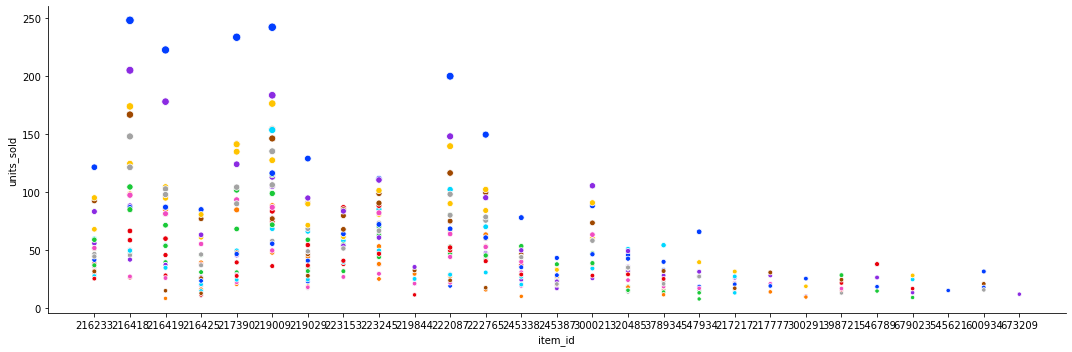

In [26]:
import plotly.graph_objects as go
plt.rcParams['figure.figsize'] = (20,10)
#sns.scatterplot(x = 'store_idx',y = 'units_sold',hue = 'item_id',data = data_store_items_reshape )
sns.relplot(x = 'item_id',y = 'units_sold',hue = 'store_idx',data = data_store_items_reshape, height=5, aspect = 3,size = 'units_sold',palette= 'bright',legend = False)

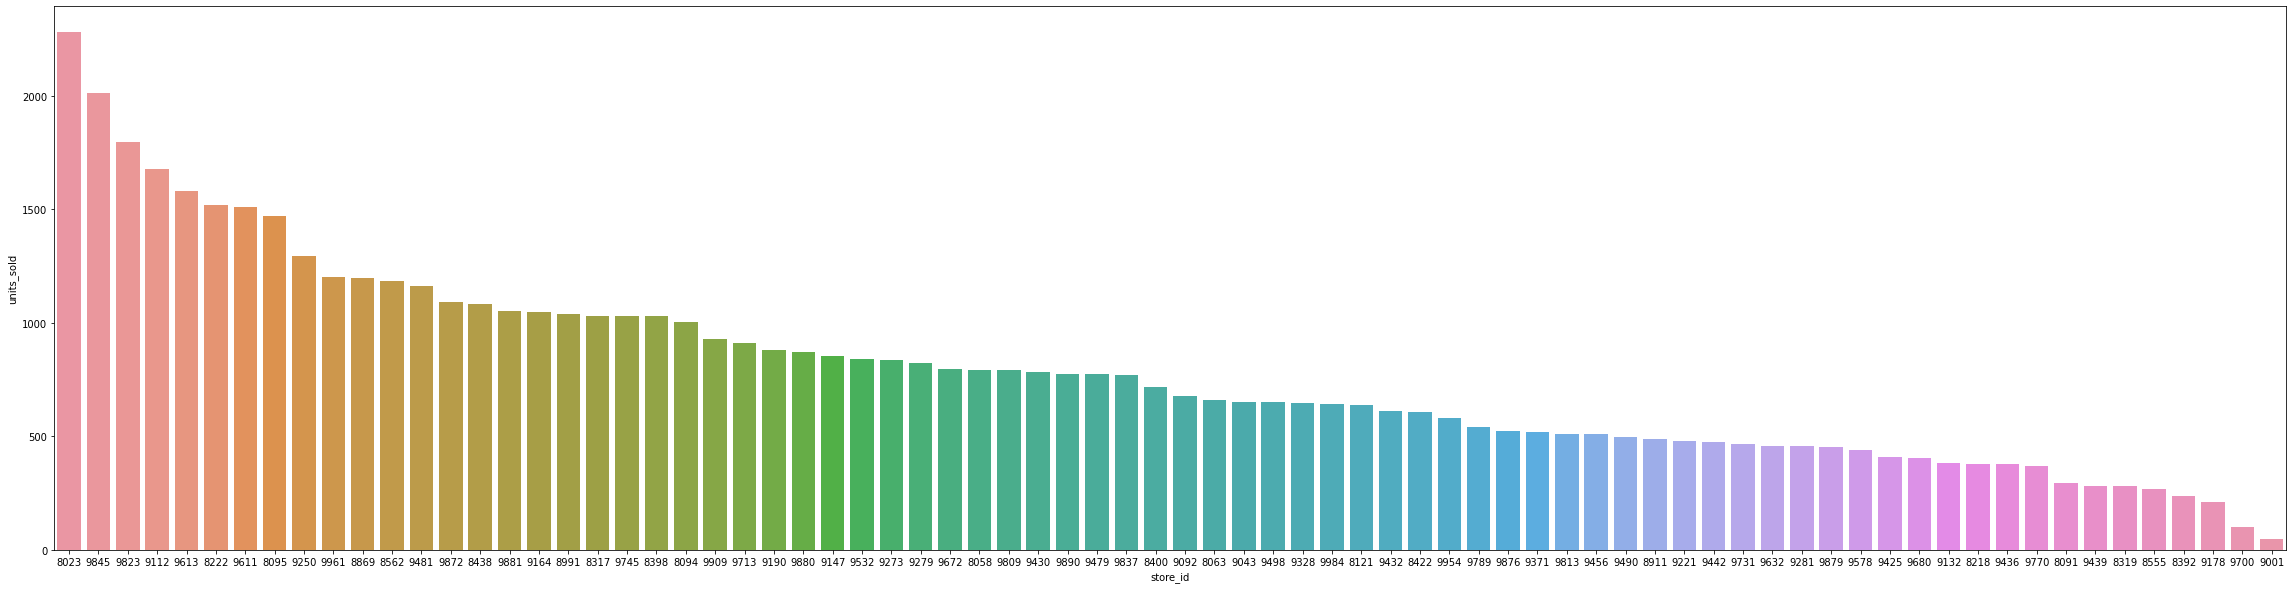

In [27]:
plt.rcParams['figure.figsize'] = (40,10)
sns.barplot(data =store_units_sold ,x ='store_id',y = 'units_sold',order = store_units_sold['store_id'])

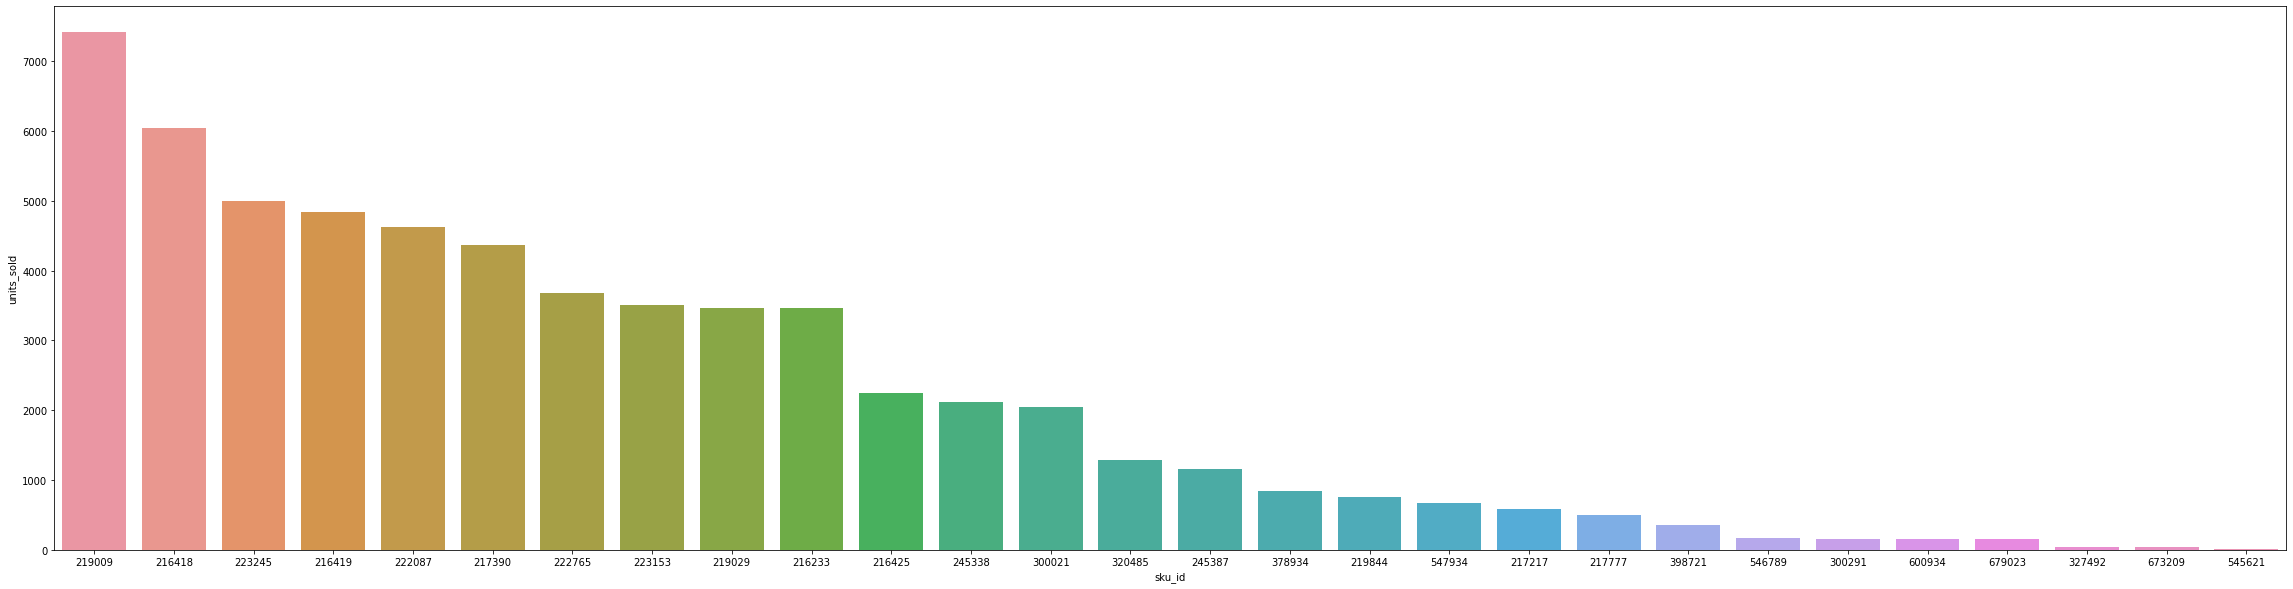

In [28]:
sns.barplot(x ='sku_id',y='units_sold',data = items_units_sold,order=items_units_sold['sku_id'])

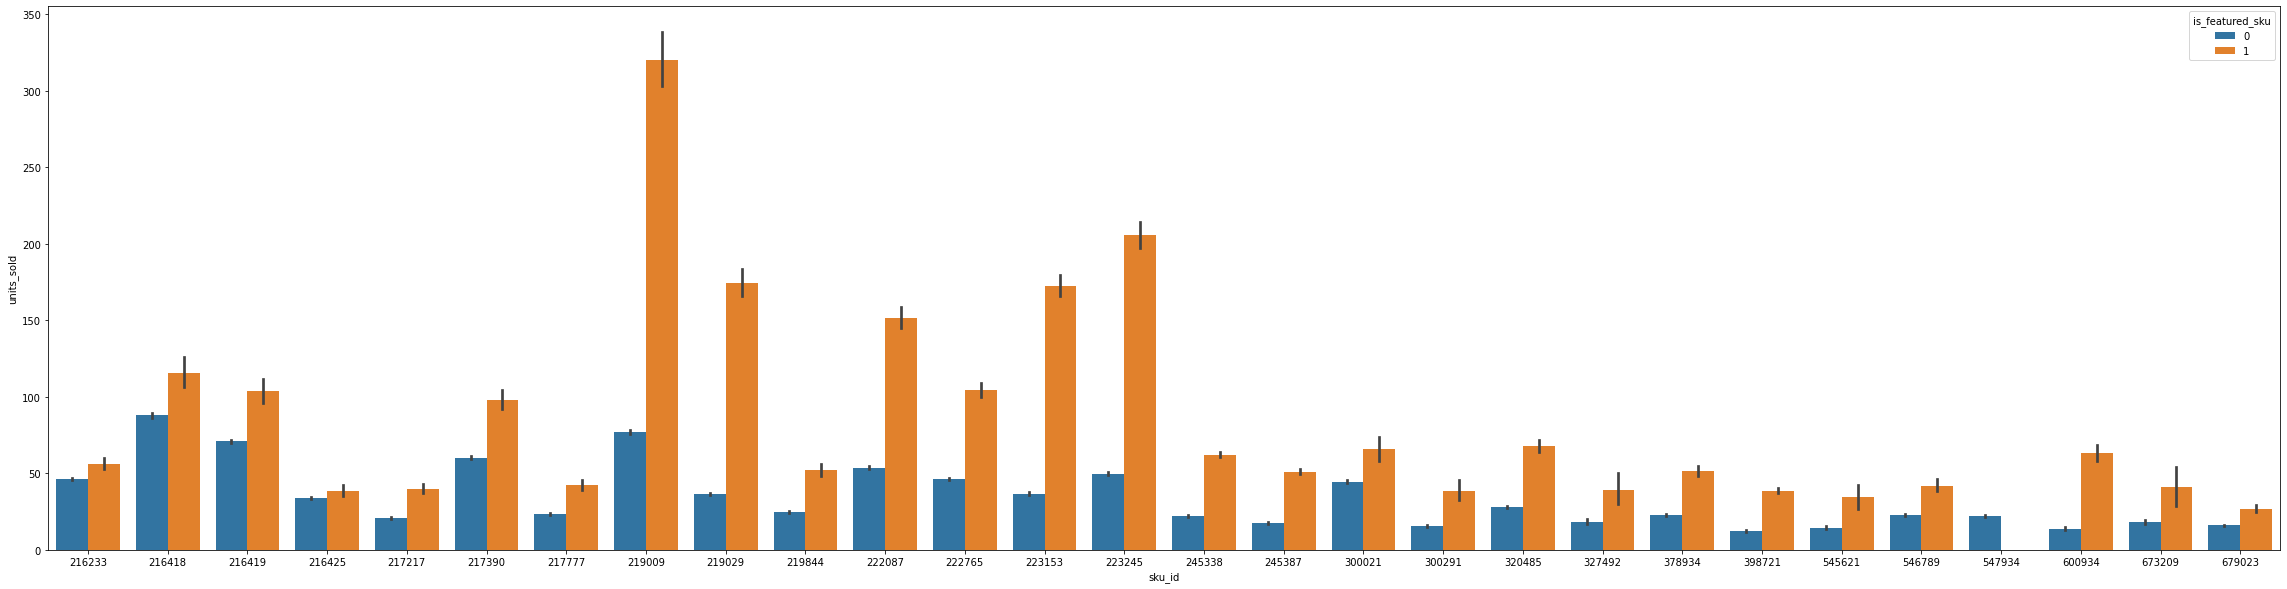

In [29]:
sns.barplot(x='sku_id',y='units_sold',hue='is_featured_sku',data = train_data,dodge=True)

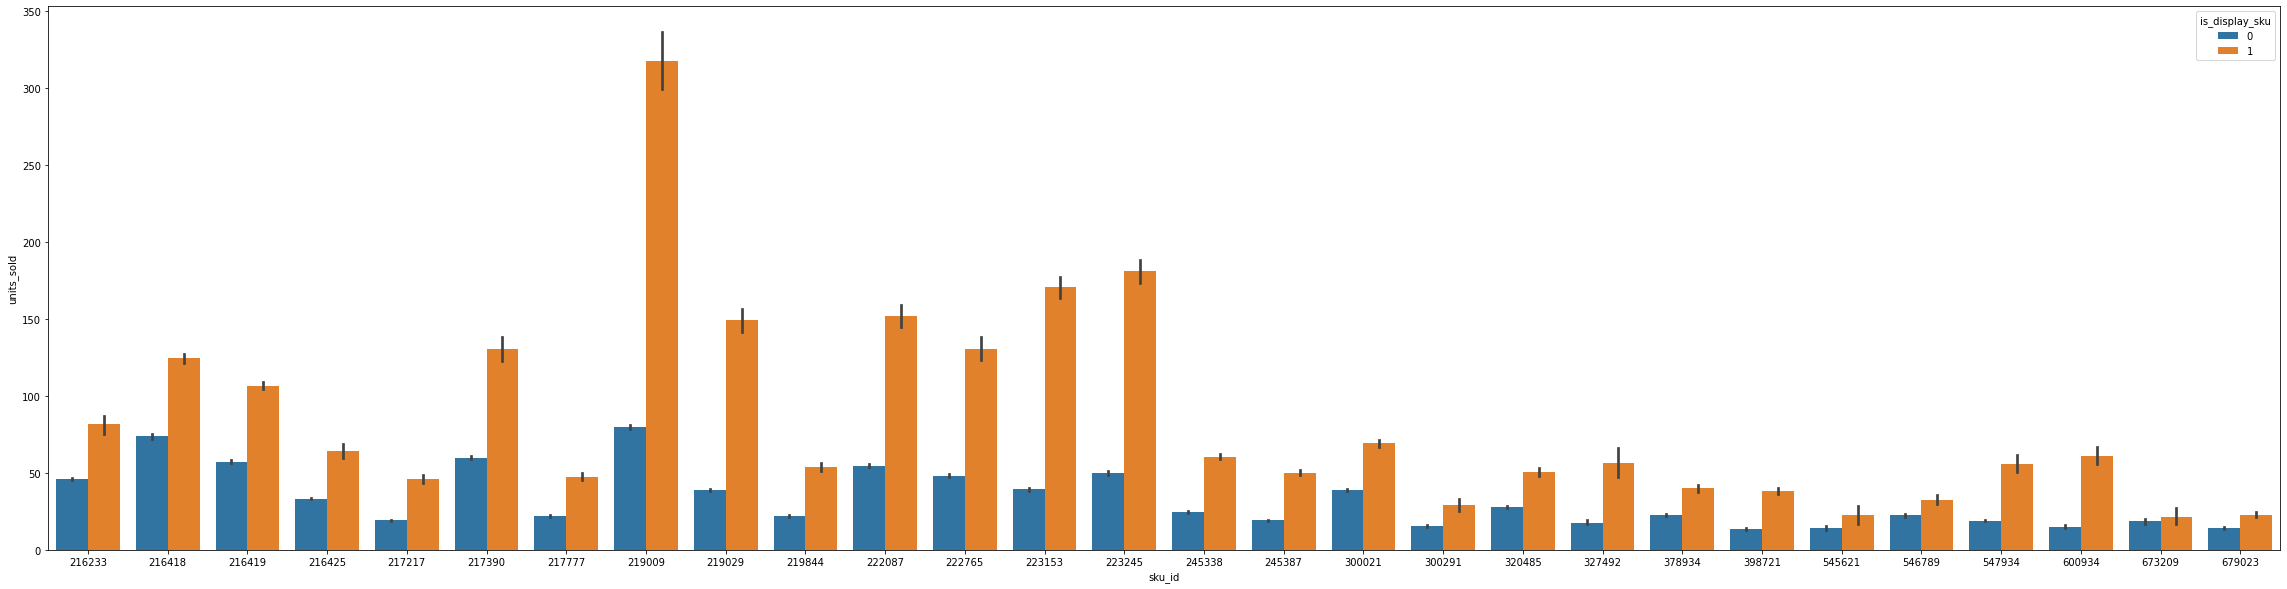

In [30]:
sns.barplot(x='sku_id',y='units_sold',hue='is_display_sku',data = train_data,dodge=True)

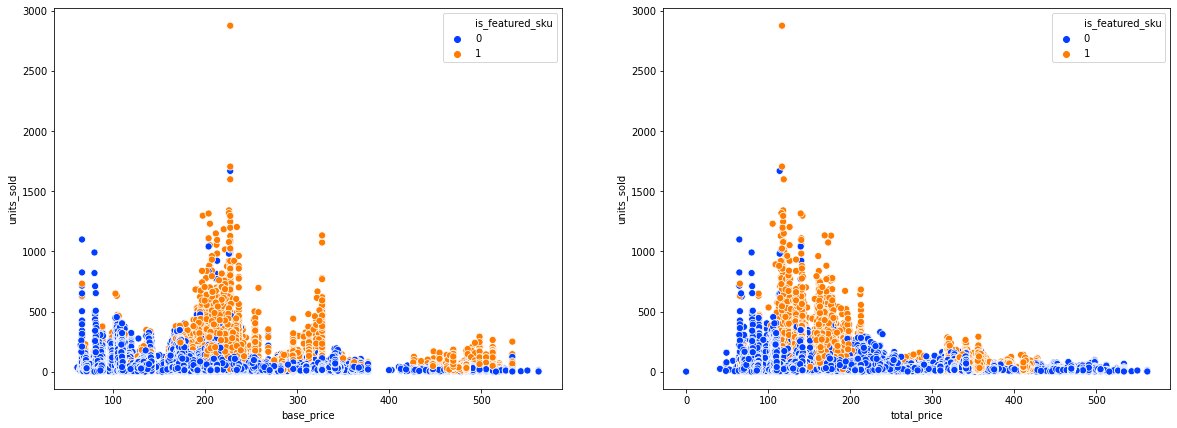

In [31]:
plt.rcParams['figure.figsize']=(20,7)
fig,axs = plt.subplots(1,2)
axs = axs.flatten()
sns.scatterplot(x= 'base_price',y='units_sold',hue='is_featured_sku',data=train_data,marker="o",alpha = 1,palette='bright',s=50,ax= axs[0])
sns.scatterplot(x= 'total_price',y='units_sold',hue='is_featured_sku',data=train_data,marker="o",alpha = 1,palette='bright',s=50,ax= axs[1])


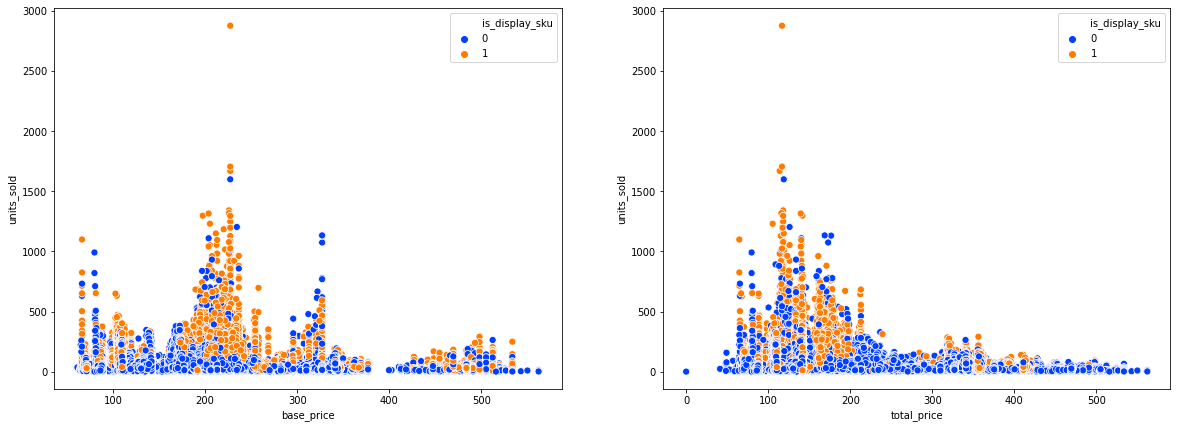

In [32]:
plt.rcParams['figure.figsize']=(20,7)
fig,axs = plt.subplots(1,2)
axs = axs.flatten()
sns.scatterplot(x= 'base_price',y='units_sold',hue='is_display_sku',data=train_data,marker="o",alpha = 1,palette='bright',s=50,ax= axs[0])
sns.scatterplot(x= 'total_price',y='units_sold',hue='is_display_sku',data=train_data,marker="o",alpha = 1,palette='bright',s=50,ax= axs[1])


In [33]:
data_wo_na = data_store_items_reshape.dropna(axis = 0,inplace = False)

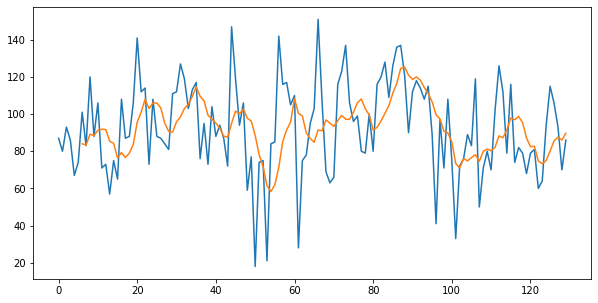

In [34]:
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(train_data['units_sold'][(train_data['store_id'] == '8095') & (train_data['sku_id'] == '216233')].values)
plt.plot(train_data['units_sold'][(train_data['store_id'] == '8095') & (train_data['sku_id'] == '216233')].rolling(7).mean().values)

In [35]:
data_store_items.fillna(value = 0)
dt = (data_store_items.set_index('index',drop = True))

In [36]:
px.imshow(dt.values)

In [37]:
data_store_items_fillna = data_store_items_reshape.fillna(0)

In [38]:
store_ids = list(train_data['store_id'].unique())
item_ids = list(train_data['sku_id'].unique())
 

In [39]:
combo_item_store = train_data.groupby(['store_id','sku_id'])['units_sold'].count().values

In [40]:
combo_values = np.zeros((len(store_ids)*len(item_ids),np.max(combo_item_store)))

In [41]:
m = 0
for i in (store_ids):

  for j in (item_ids):

    if (train_data['units_sold'][(train_data['store_id'] == i)&(train_data['sku_id'] == j)]).empty == False:

      l = len((train_data['units_sold'][(train_data.store_id == i)&(train_data.sku_id == j)]))
      combo_values[m,:l] = (train_data['units_sold'][(train_data.store_id == i)&(train_data.sku_id == j)]).values.reshape(1,-1)


      m = m+1 

      if m == len(combo_values):

        break


In [42]:
combo_values = pd.DataFrame(combo_values)

In [46]:
combo_values.replace(to_replace = 0, value = np.nan,inplace = True)

In [64]:
train_data

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,week_num
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,2011,1,3
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,2011,1,3
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,2011,1,3
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,2011,1,3
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,2011,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-07-09,9984,223245,235.8375,235.8375,0,0,38,2013,7,28
150146,212639,2013-07-09,9984,223153,235.8375,235.8375,0,0,30,2013,7,28
150147,212642,2013-07-09,9984,245338,357.6750,483.7875,1,1,31,2013,7,28
150148,212643,2013-07-09,9984,547934,141.7875,191.6625,0,1,12,2013,7,28
